In [38]:
# hack to import local classes
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

from src.models import train_model
from src.data import read_transform
from sklearn.metrics import calinski_harabaz_score

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack, save_npz, load_npz

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Read CSR matrix from the input file
csrMatrix = read_transform.csr_read('../data/raw/train.dat')

#Scale the CSR matrix by idf (Inverse Document Frequency)
csrIDF = read_transform.csr_idf(csrMatrix, copy=True)

#Normalize the rows of a CSR matrix by their L-2 norm.
csrL2Normalized = read_transform.csr_l2normalize(csrIDF, copy=True)

#Obtain a dense ndarray representation of the CSR matrix.
denseMatrix = csrL2Normalized.toarray()

In [3]:
from sklearn.decomposition import TruncatedSVD

In [4]:
pca = TruncatedSVD(2)

In [5]:
col_pca = pca.fit_transform(csrL2Normalized.T)

In [6]:
dfPca = pd.DataFrame(col_pca)

In [7]:
dfPca = dfPca.rename(index=str, columns={0: "x", 1: "y"})

In [8]:
dfPca.columns

Index(['x', 'y'], dtype='object')

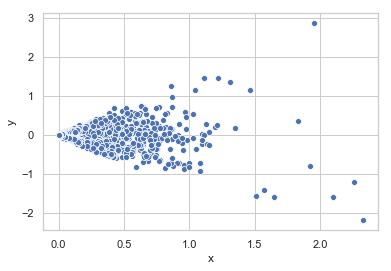

In [9]:
sns.scatterplot(x="x", y="y", data=dfPca)

In [42]:
dfPca.head()

,x,y,db_labels
0,0.033400,0.015718,-1
1,0.023335,0.008592,-1
2,0.315913,0.050079,-1
3,0.364635,0.195704,-1
4,0.300061,0.026404,-1


### Term Clustering

Cluster columns instead of rows in order to find term clustering and use those cluster centroids as features to reduce dimensions.

In [43]:
denseMatrix.T.shape

(126355, 8580)

In [44]:
from sklearn.cluster import KMeans

In [45]:
km = KMeans(n_clusters=10000, init='k-means++', max_iter=100, random_state=10, n_jobs=-1)

In [14]:
km.fit(csrL2Normalized.T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [15]:
dfPca['km_labels'] = km.labels_ + 1

In [18]:
dfPca.head()

,0,1,km_labels
0,0.033399,0.015689,1
1,0.023335,0.008596,1
2,0.315915,0.050097,5
3,0.364636,0.195665,5
4,0.300058,0.026335,5


In [16]:
dfPca.km_labels.value_counts()

1    125726
5       621
2         4
3         3
4         1
Name: km_labels, dtype: int64

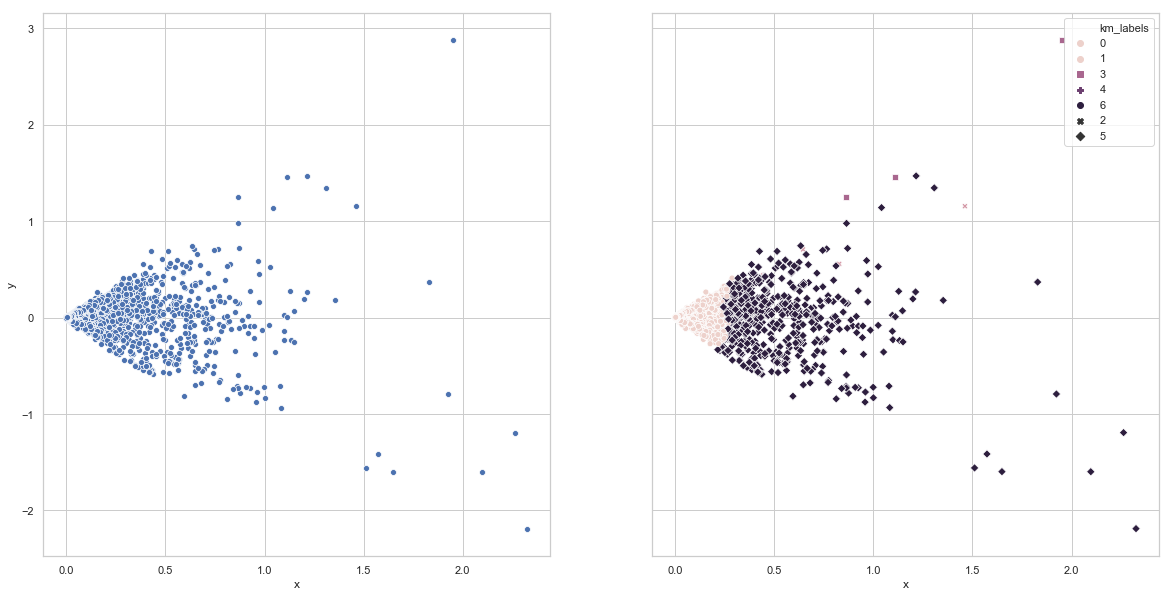

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20,10))
sns.scatterplot(x="x", y="y", data=dfPca, ax=ax1)
sns.scatterplot(x="x", y="y",hue="km_labels", style="km_labels", data=dfPca, ax=ax2)

In [10]:
from sklearn.cluster import DBSCAN

In [46]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine', n_jobs=-1)

In [47]:
dbscan.fit(csrL2Normalized.T)

KeyboardInterrupt: 

In [13]:
pd.DataFrame(dbscan.labels_)[0].value_counts()

-1     124785
 2        517
 0        226
 1        209
 3        190
 6         82
 4         81
 9         65
 8         58
 5         58
 10        50
 7         23
 11        11
Name: 0, dtype: int64

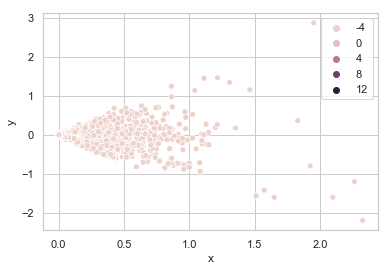

In [14]:
sns.scatterplot(x = dfPca['x'], y = dfPca['y'], hue=dbscan.labels_)

In [15]:
dbscan.components_

<833x8580 sparse matrix of type '<class 'numpy.float64'>'
	with 1127 stored elements in Compressed Sparse Row format>

In [17]:
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

In [18]:
n_clusters_

12

In [20]:
dfPca['db_labels'] = dbscan.labels_

In [21]:
dfPca.db_labels.value_counts()

-1     124785
 2        517
 0        226
 1        209
 3        190
 6         82
 4         81
 9         65
 8         58
 5         58
 10        50
 7         23
 11        11
Name: db_labels, dtype: int64

In [23]:
dfPca.shape

(126355, 3)

In [25]:
dfPca[dfPca.db_labels!=-1].head()

,x,y,db_labels
281,0.000089,0.000056,3
589,0.001432,0.001070,0
1872,0.003397,0.002268,2
2639,0.000260,0.000275,1
3085,0.000354,0.000242,2


In [31]:
nonNoiseIndices = dfPca[dfPca.db_labels!=-1].index

In [33]:
nonNoiseIndices = np.array(nonNoiseIndices, dtype=np.int)

In [36]:
csr_term_clustered = csr_matrix(denseMatrix[:, nonNoiseIndices])

In [39]:
save_npz('../data/interim/csr_term_clustered_dbs-05_50.npz', csr_term_clustered)